In [1]:
import sys
import os
import pandas as pd
from pathlib import Path


In [2]:
# Añadir el directorio src al path de Python
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)


In [3]:
from calculadora_margen.cleaning.cleaner_df import DataFrameCleaner
from calculadora_margen.config.parameters import Parameters
from calculadora_margen.services.validator import Validator
from calculadora_margen.services.outliers_manager import OutliersManager
from calculadora_margen.services.cost_calculator import CostCalculator
from calculadora_margen.services.encoder import Encoder
from calculadora_margen.services import VisualizationManager

In [4]:
project_root_path = Path(src_path).parent
data_path = project_root_path / 'data'
raw_path = data_path / 'raw'
clean_path = data_path / 'clean'

ETL master_lotes

In [5]:
master_lotes = pd.read_csv(raw_path / 'costes.csv',  encoding='UTF-8', sep=';', dtype=str)

In [6]:
cleaner = DataFrameCleaner(master_lotes)
params = Parameters.master_lotes

master_lotes = (cleaner
    .columns_cleaner.keep_and_rename(params.cols_to_keep, params.rename_map)
    .rows_cleaner.drop_duplicates()
    .rows_cleaner.drop_na(params.drop_na_subset)
    .data_cleaner.to_upper()
    .get_df()
)

In [7]:
validator = Validator(master_lotes)
master_lotes = (validator
    .validate_with_map(params.validation_map)
    .get_df()
)

In [8]:
# Creamos clave única para poder hacer merge en otros df
encoder = Encoder(master_lotes)
master_lotes = encoder.create_key(col1='articulo', col2='lote_proveedor', new_col_name='clave_merge')

In [9]:
duplicados = master_lotes['clave_merge'].duplicated().sum()
duplicados

np.int64(0)

In [10]:
master_lotes.sample(2)

,articulo,lote_proveedor,lote_componente,clave_merge
5204,FCAR019,141019,141019,FCAR019-141019
6730,FCAR001,181122,181122,FCAR001-181122


In [11]:
master_lotes.to_csv(clean_path / 'master_lotes_clean.csv', index=False)

ETL costes

In [12]:
costes = pd.read_csv(raw_path / 'costes.csv',  encoding='UTF-8', sep=';', dtype=str)

In [13]:
cleaner = DataFrameCleaner(costes)
params = Parameters.costes

costes = (cleaner
    .rows_cleaner.drop_na(params.drop_na_subset)
    .rows_cleaner.drop_duplicates()
    .columns_cleaner.keep_and_rename(params.cols_to_keep, params.rename_map)
    .data_cleaner.fix_numeric_format(params.cols_to_float)
    .rows_cleaner.drop_duplicates_batch(params.drop_duplicates_subset)
    .data_cleaner.to_upper()
    .get_df()
)

In [14]:
validator = Validator(costes)

costes = (validator
    .validate_with_map(params.validation_map)
    .get_df()
)


=== RESUMEN DE VALIDACIÓN ===
Tamaño inicial del DataFrame: 8000

Filas inválidas por columna:
  - componente: 1 filas
  - lote_componente: 21 filas

Tamaño final del DataFrame: 7978
Total filas eliminadas: 22


In [15]:
# Ver las filas inválidas para una columna específica
#invalid_rows = validator.get_invalid('lote_interno')
#print(invalid_rows.head(10))

In [16]:
outliers_manager = OutliersManager(costes, Parameters.costes)
costes_procesados = (outliers_manager
    .process_outliers()
    .clean_columns()
    .get_df()
)


=== RESUMEN DE OUTLIERS ===
Outliers detectados inicialmente: 71
Outliers reemplazados por la media: 66
Outliers restantes: 5


In [17]:
costes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7978 entries, 6788 to 17055
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   componente                 7978 non-null   object 
 1   coste_componente_unitario  7978 non-null   float64
 2   lote_componente            7978 non-null   object 
dtypes: float64(1), object(2)
memory usage: 249.3+ KB


In [18]:
costes.sample(2)

,componente,coste_componente_unitario,lote_componente
11868,MAUX020,0.2328,2206-036
8330,MAT099,7.3310,2002-050


In [19]:
costes.to_csv(clean_path / 'costes_clean.csv', index=False)

ETL fabricaciones

In [20]:
fabricaciones = pd.read_csv(raw_path / 'fabricaciones_2025.csv',  encoding='UTF-8', sep=';', dtype=str)

In [21]:
# No queremos trabajar con lote_componente_proveedor, unimos a master_lotes para obtener lote_componente
fabricaciones = Encoder(fabricaciones).create_key(col1='Componente', col2='Lote Componente', new_col_name='clave_merge')
fabricaciones = fabricaciones.merge(master_lotes, on="clave_merge", how="left")

# Merge fabricaciones y costes
fabricaciones = Encoder(fabricaciones).create_key(col1='articulo', col2='lote_componente', new_col_name='clave_merge')
costes = Encoder(costes).create_key(col1='componente', col2='lote_componente', new_col_name='clave_merge')
fabricaciones = fabricaciones.merge(costes, on="clave_merge", how="left")

# Creamos clave única para usar la función recursiva de costes
fabricaciones = Encoder(fabricaciones).create_key(col1='Producto', col2='Lote Producto', new_col_name='clave_unica')

In [22]:
cleaner = DataFrameCleaner(fabricaciones)
params = Parameters.fabricaciones

fabricaciones = (cleaner
    .rows_cleaner.drop_duplicates()
    .columns_cleaner.keep_and_rename(params.cols_to_keep, params.rename_map)
    .data_cleaner.fix_numeric_format(params.cols_to_float)
    .data_cleaner.fix_date_format(['fecha_fabricacion'])
    .rows_cleaner.drop_na(params.drop_na_subset)
    .data_cleaner.to_upper()
    .get_df()
)

In [23]:
# Crear instancia del calculador y calcular costes
calculador = CostCalculator(fabricaciones)
fabricaciones = calculador.calcular_costes_recursivamente()

Estado inicial: 2961 registros pendientes de calcular coste

Resumen por estado de cálculo:
Artículos pendientes: 112
Artículos calculados: 37

1ª iteración:
Registros sin coste: 2961

2ª iteración:
Registros sin coste: 1635

3ª iteración:
Registros sin coste: 384

4ª iteración:
Registros sin coste: 11

5ª iteración:
Registros sin coste: 11
No se pueden calcular más costes.

Resumen final:
Total registros: 19583
Registros sin coste: 11
Registros con coste calculado: 19572


In [24]:
fabricaciones.to_csv(clean_path / 'fabricaciones_clean.csv', index=False)

In [25]:
# Luego generar el resumen de costes de fabricación
costes_fabricacion = calculador.generar_costes_fabricacion()

ADVERTENCIA: Hay costes pendientes de calcular. Los resultados pueden ser incompletos.

Resumen de costes de fabricación:
Total órdenes procesadas: 2633
Rango de fechas: 2024-01-02 00:00:00 a 2025-03-28 00:00:00


In [26]:
outliers_manager = OutliersManager(costes_fabricacion, Parameters.costes_fabricacion)

costes_fabricacion = (outliers_manager
    .process_outliers()
    .clean_columns()
    .get_df()
)


=== RESUMEN DE OUTLIERS ===
Outliers detectados inicialmente: 39
Outliers reemplazados por la media: 35
Outliers restantes: 4


In [27]:
costes_fabricacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633 entries, 0 to 2632
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_orden             2633 non-null   object        
 1   fecha_fabricacion    2633 non-null   datetime64[ns]
 2   articulo             2633 non-null   object        
 3   unidades_fabricadas  2633 non-null   float64       
 4   coste_unitario       2633 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 103.0+ KB



Estadísticas para SCRE036:
Media: 0.77
Desv. Est.: 0.01
Min: 0.74
Max: 0.80


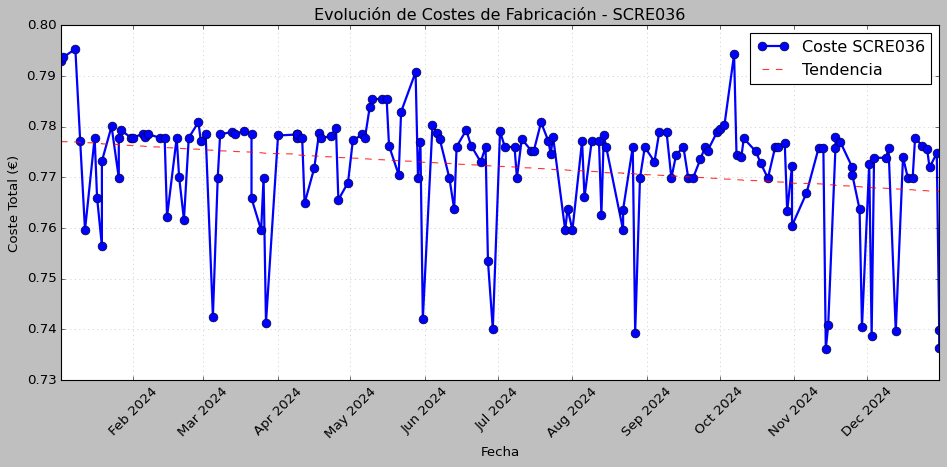

In [28]:
# Crear el visualizador
viz_manager = VisualizationManager(costes_fabricacion, Parameters.costes_fabricacion)

# Visualizar un artículo específico
viz_manager.plot_time_series(
    articulo='SCRE036',
    start_date='2024-01-01',
    end_date='2024-12-31'
)

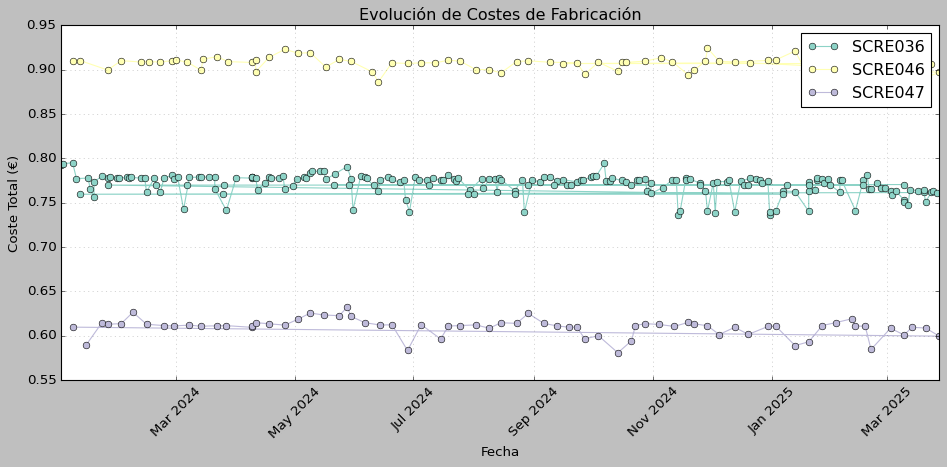

In [30]:
# Comparar varios artículos
viz_manager.plot_multiple_time_series(
    articulos=['SCRE036', 'SCRE046', 'SCRE047']
)